# Chapter 2 Code

Covers code for Chapter 2, "Pretraining Strategies and Transfer Learning", of *Modern Deep Learning Design and Application*.

---

## Installing + Importing Libraries

In [ ]:
# array processing + math
import numpy as np
import pandas as pd
import scipy
import math

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# looping - very helpful for data manpulation scripts
from tqdm.notebook import tqdm

# deep learning staple libraries
# !pip install tensorflow # install if necessary
import sklearn
import tensorflow as tf
from tensorflow import keras

# keras specifics
import keras.layers as L
import keras.backend as K
from keras.utils import plot_model

---

## Loading Chapter Dataset

The chapter dataset is custom-modified version of the CelebA dataset, containing an image of a celebrity's face and the associated gender of the celebrity.

Download the `zipped_celeba_data.zip` file and load it using the below script. This reads in data from the data and converts it into a TensorFlow dataset. The `max_lim` variable allows you to specify the number of data instances for each gender in the dataset.

You can use this dummy dataset to perform pretraining. Adjust the directory based on where you have placed them.

In [ ]:
image_directories, labels = [], []

num_male, num_female = 0, 0
max_lim = 5000

import os
for dirname, _, filenames in os.walk('input_directory/'):
    for filename in filenames:
        if dirname == 'input_directory/data/male' and num_male != max_lim:
            image_directories.append(os.path.join(dirname, filename))
            labels.append(1)
            num_male += 1
            
        elif dirname == 'input_directory/data/male' and num_female != max_lim:
            image_directories.append(os.path.join(dirname, filename))
            labels.append(0)
            num_female += 1
    if num_female == max_lim and num_male == max_lim: break

arr = np.array(list(zip(image_directories, labels)))
np.random.shuffle(arr)
unparsed = tf.data.Dataset.from_tensor_slices((arr[:,0],arr[:,1].astype(np.int)))

def parse_files(filename, label): 
    raw_image = tf.io.read_file(filename) 
    image = tf.image.decode_png(raw_image, channels=3) 
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [512,512]) 
    return image, label 

data = unparsed.map(parse_files)
data = data.batch(8)

---

## Transfer Learning

### No Architecture or Weight Changes

Retrieving and visualizing input data to ImageNet model.

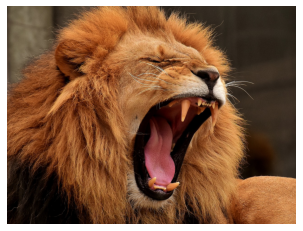

In [ ]:
import PIL, requests
from PIL import Image
url = 'https://cdn.pixabay.com/photo/2018/04/13/21/24/lion-3317670_1280.jpg'
im = np.array(Image.open(requests.get(url, stream=True).raw))

plt.imshow(im)  # display array
plt.axis('off') # turn off axes
plt.show()      # show figure

Create transfer learning model using InceptionV3 base model.

In [ ]:
# importing relevant layers and models
from keras.layers import Input
from keras.layers.experimental.preprocessing import Resizing
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# defining input pipeline
input_layer = Input((None, None, 3))
reshape_layer = Resizing(299,299)(input_layer)
preprocess_layer = preprocess_input(reshape_layer)

# defining base model
inceptionv3 = InceptionV3(include_top=True, weights='imagenet')(preprocess_layer)

# create model
model = keras.models.Model(inputs=input_layer, outputs=inceptionv3)

96116736/96112376 [==============================] - 1s 0us/step


Predict on input image and decode.

In [ ]:
from keras.applications.inception_v3 import decode_predictions
reshaped_im = np.array([im])
decode_predictions(model.predict(reshaped_im))

40960/35363 [==================================] - 0s 0us/step


[[('n02129165', 'lion', 0.8908843),
  ('n02112137', 'chow', 0.010042933),
  ('n02130308', 'cheetah', 0.0034918315),
  ('n02115913', 'dhole', 0.001121299),
  ('n04328186', 'stopwatch', 0.0011171916)]]

### Transfer Learning Without Layer Freezing

Define the transfer learning model.

87916544/87910968 [==============================] - 0s 0us/step


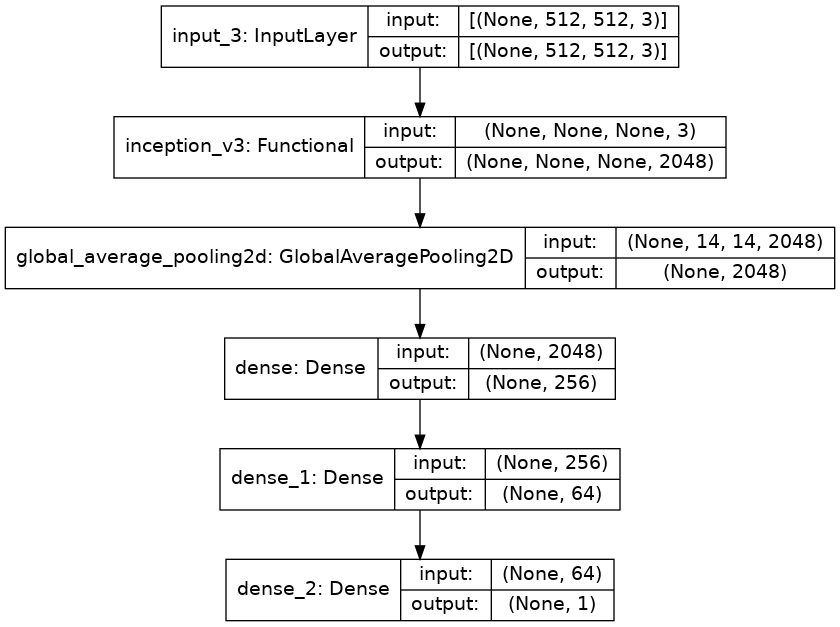

In [ ]:
# importing relevant layers and models
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3

# building model
input_layer = Input((512,512,3))
inceptionv3 = InceptionV3(include_top=False,
                          weights='imagenet')(input_layer)
pooling = GlobalAveragePooling2D()(inceptionv3)
custom_dense_1 = Dense(256, activation='relu')(pooling)
custom_dense_2 = Dense(64, activation='relu')(custom_dense_1)
output_layer = Dense(1, activation='sigmoid')(custom_dense_2)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)

# plot model
plot_model(model, show_shapes=True)

Train on chapter dataset.

In [ ]:
# feel free to add callbacks, metrics, history plotting, and other deep learning good practices
model.compile(optimizer='adam',
              loss='binary_crossentropy')
model.fit(data, epochs=1) # train for more epochs for better results.

1250/1250 [==============================] - 259s 201ms/step - loss: 0.6623


### Transfer Learning With Layer Freezing

Create transfer learning model.

In [ ]:
# instantiate inception base model
inception_model = InceptionV3(include_top=False, weights='imagenet')

# build transfer learning model
input_layer = Input((512,512,3))
inceptionv3 = inception_model(input_layer)
pooling = GlobalAveragePooling2D()(inceptionv3)
custom_dense_1 = Dense(256, activation='relu')(pooling)
custom_dense_2 = Dense(64, activation='relu')(custom_dense_1)
output_layer = Dense(1, activation='sigmoid')(custom_dense_2)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)

# view trainable and untrainable parameter counts
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 22,343,841
Trainable params: 22,309,409
Non-trainable params: 34,432
__________________________________________

Freeze base model and view effect on trainable vs non-trainable parameters.

In [ ]:
# freeze inception model weights
inception_model.trainable = False

# view trainable and untrainable parameter counts
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 22,343,841
Trainable params: 541,057
Non-trainable params: 21,802,784
_________________________________________

Initiate training routine.

In [ ]:
# compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy')

# fit model w/ weight freezing
model.fit(data, epochs=1) # train for more epochs for better results

# unfreeze model
inception_model.trainable = True

# continue fitting w/out weight freezing
model.fit(data, epochs=1) # train for more epochs for better results

1250/1250 [==============================] - 76s 61ms/step - loss: 0.2074


### Accessing PyTorch Models

Run necessary installations.

In [ ]:
# !pip install torch # run if pytorch is not already installed
!pip install torchvision # run if torch vision is not already installed
!pip install pytorch2keras # run if pytorch2keras is not already installed

  Created wheel for pytorch2keras: filename=pytorch2keras-0.2.4-py3-none-any.whl size=29664 sha256=fb267ad11feb73cc80c247334924b6be2a362a8ffabc361470f4d8342ea5004e
  Stored in directory: /root/.cache/pip/wheels/72/4e/ee/8c004883e677ab4283783ffd9433ecf595327889dd367c79b1
  Created wheel for onnx2keras: filename=onnx2keras-0.0.24-py3-none-any.whl size=24580 sha256=7151115db28f19f86c3565e9a9f971ddcabc6e2ef7a51842b7412e40ae99d580
  Stored in directory: /root/.cache/pip/wheels/21/29/29/227fc9f8fed234b12169ae41f979cfadf1dcdbe1b370a5bbb5
Successfully built pytorch2keras onnx2keras


Convert sample PyTorch model (SqueezeNet) to Keras.

In [ ]:
# instantiate pytorch squeezenet model w/ pretrained weights
from torchvision import models
pytorch_model = models.squeezenet1_0(pretrained=True)

# import conversion
from pytorch2keras.converter import pytorch_to_keras

# convert from pytorch model to Keras model
from torch.autograd import Variable
from torch import FloatTensor
input_np = np.random.uniform(0, 1, (1, 3, 256, 256))
input_var = Variable(FloatTensor(input_np))
keras_model = pytorch_to_keras(pytorch_model,
                               input_var, 
                               [(3, None, None,)]) 

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


  0%|          | 0.00/4.79M [00:00<?, ?B/s]

Plot converted PyTorch model architecture.

In [ ]:
# plot_model(keras_model, show_shapes=True)

---

## (Simple) Self-Supervised Learning

We'll explore more complex usages of self-supervised learning in the next chapter, when we have acquired knowledge of the autoencoder structure.

Creating altered task dataset (quantifying noise):

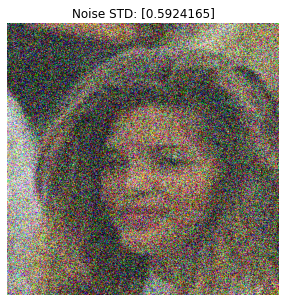

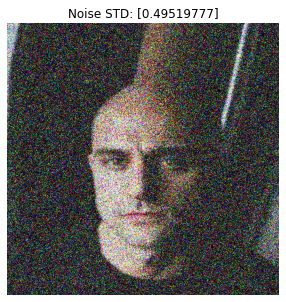

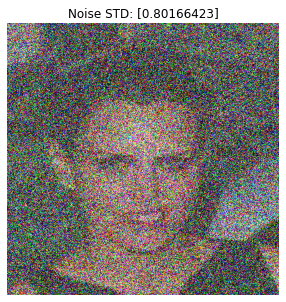

In [ ]:
# function to parse only file
def parse_file(filename):
    raw_image = tf.io.read_file(filename) 
    image = tf.image.decode_png(raw_image, channels=3) 
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [512,512])
    return image

# add random gaussian noise to image
def alter_data(filename, label): 
    image = parse_file(filename)
    std = tf.random.uniform(shape=[1], minval=0, maxval=1)
    noise = tf.random.normal(shape=tf.shape(image), 
                             mean=0.0, 
                             stddev=std, 
                             dtype=tf.float32)
    image = tf.add(image, noise)
    return image, std

# create altered task dataset
altered_task_data = unparsed.map(alter_data)

# visualize items from altered task dataset
it = iter(altered_task_data) # convert to iterator
for i in range(3): # display 3 images
    item = it.next() # obtain data instance
    
    # obtain image + reformat image channels; if this step is not performed images will look blue
    img = item[0].numpy()
    im2 = img.copy()
    im2[:, :, 0] = img[:, :, 2]
    im2[:, :, 2] = img[:, :, 0]
    
    plt.figure(figsize=(5,5))
    plt.imshow(im2) # show image
    plt.axis('off')
    plt.title(f'Noise STD: {item[1].numpy()}') # title image with label
    plt.show() # show image

# batch data before training
altered_task_data = altered_task_data.batch(8)

Train Inceptionv3 architecture on altered task dataset, then train on true dataset.

In [ ]:
# initiate inception architecture (without weights)
input_layer = Input((512,512,3))
inceptionv3 = InceptionV3(include_top=True,
                          input_shape=(512,512,3),
                          weights=None,
                          classes=1)(input_layer)
model = keras.models.Model(inputs=input_layer, outputs=inceptionv3)
model.compile(optimizer='adam',
              loss='binary_crossentropy')

# fit model on altered task dataset
model.fit(altered_task_data, epochs=1)

# fit model on task dataset
model.fit(data, epochs=1)

# train for more epochs for better results!

1250/1250 [==============================] - 255s 201ms/step - loss: 0.7078


---

## Case Study: Predicting Rotations

Load and generate data.

In [ ]:
# load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# generate self-supervised data
from scipy.ndimage import rotate
ss_x_train, ss_y_train = [], []
for ind in tqdm(range(len(x_train))):
    rot = np.random.choice([0, 90, 180, 270])
    if rot==0:
        ss_x_train.append(rotate(x_train[ind], rot))
        ss_y_train.append([1,0,0,0])
    elif rot==90:
        ss_x_train.append(rotate(x_train[ind], rot))
        ss_y_train.append([0,1,0,0])
    elif rot==180:
        ss_x_train.append(rotate(x_train[ind], rot))
        ss_y_train.append([0,0,1,0])
    elif rot==270:
        ss_x_train.append(rotate(x_train[ind], rot))
        ss_y_train.append([0,0,0,1])
ss_x_train = np.array(ss_x_train)
ss_y_train = np.array(ss_y_train)

170500096/170498071 [==============================] - 11s 0us/step


  0%|          | 0/50000 [00:00<?, ?it/s]

Initialize EfficientNet architecture and train.

In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from keras.models import Model

inp = L.Input((32,32,3))
base = EfficientNetB4(input_tensor=inp,
                      weights=None,
                      classes=100)
out = L.Dense(4, activation='softmax')(base.output)
model = Model(inputs=inp,
              outputs=out)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(ss_x_train, ss_y_train,
          epochs=1) # train for more epochs for better results

1563/1563 [==============================] - 128s 72ms/step - loss: 1.3877 - accuracy: 0.2519


Extract base model from self-supervised learning and adapt for CIFAR-10 dataset.

In [ ]:
inp = L.Input((32,32,3))
base_out = base(inp)
out = L.Dense(10, activation='softmax')(base_out)
model = Model(inputs=inp,
              outputs=out)
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          epochs=1) # train for more epochs for better results

1563/1563 [==============================] - 120s 68ms/step - loss: 2.3036 - accuracy: 0.1130


---

## Versions

See versions for all libraries used if you run into any errors.

In [ ]:
!pip list

Package                        Version             Location
------------------------------ ------------------- --------------
absl-py                        0.12.0
adal                           1.2.6
affine                         2.3.0
aiobotocore                    1.3.0
aiohttp                        3.7.4
aiohttp-cors                   0.7.0
aioitertools                   0.7.1
aioredis                       1.3.1
albumentations                 0.5.2
alembic                        1.5.8
allennlp                       2.3.0
altair                         4.1.0
annoy                          1.17.0
ansiwrap                       0.8.4
appdirs                        1.4.4
argon2-cffi                    20.1.0
arrow                          1.0.3
arviz                          0.11.2
asn1crypto                     1.4.0
astunparse                     1.6.3
async-generator                1.10
async-timeout                  3.0.1
attrs                          20.3.0
audioread          

---